#### Some of the necessary imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
#from metabolinks import read_aligned_spectra, read_spectra_from_xcel, AlignedSpectra
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

#### Read (reload) aligned from CSV - Building the datasets

### All Positive Mode

Two files:

Norm - '5yeasts_norm_11_12.csv' - Dataset already normalized by the reference feature Leucine Enkephalin in MetaboScape (equal to the normalization function in scaling.py but having all leucine peaks at a certain intensity instead of 1 as it happens in the scaling.py module). m/z delta = 1

None - '5yeasts_notnorm_2.csv' - Dataset without any kind of normalization made by MetaboScape. m/z delta = 1,1

Binary analysis for each one should be identical but as they have a slightly different alignment (m/z delta parameter), they will be slightly different.

#### "None" dataset is more relevant than Norm.

### Read in the two files

In [3]:
def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

leu_enk_name = '555.2692975341 Da'

def reading_MetScape_file(filename,
                          col_renamer=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    peak_cols = ['m/z', 'Name', 'Formula']
    intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    peaks = data[peak_cols]
    intensities = data[intensity_cols]

    # replace zeros for NaN's
    intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    peaks = peaks.reindex(intensities.index)
    
    return (peaks, intensities)

In [4]:
peaks = {}
intensities_nan = {}
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this

# Read in the two files and keep results in dicts 

prefix_to_drop = None
peaks_norm, yeast_norm = reading_MetScape_file('5yeasts_norm_11_12.csv', 
                                                remove_ref_feat=leu_enk_name,
                                                col_renamer=renamer,
                                                prefix_to_drop=prefix_to_drop)

yeast_norm = mtl.add_labels(yeast_norm, labels=labels)

peaks['Norm'] = peaks_norm
intensities_nan['Norm'] = yeast_norm

prefix_to_drop = None
peaks_none, yeast_none = reading_MetScape_file('5yeasts_notnorm_2.csv', 
                                                remove_ref_feat=leu_enk_name,
                                                col_renamer=renamer,
                                                prefix_to_drop=prefix_to_drop)

yeast_none = mtl.add_labels(yeast_none, labels=labels)

peaks['None'] = peaks_none
intensities_nan['None'] = yeast_none

intensities_nan

{'Norm': label                     BY4741                                     dGRE3  \
                            BY0_1         BY0_2         BY0_3        GRE3_1   
 Bucket label                                                                 
 307.0838178877 Da   1.482951e+09  1.520914e+09  1.515563e+09  1.231184e+09   
 624.0873082632 Da   4.933358e+08  4.858229e+08  4.977819e+08  5.939113e+08   
 493.3168156897 Da   4.026932e+08  4.174214e+08  4.232130e+08  4.742500e+08   
 257.1028750516 Da   2.056732e+08  2.052868e+08  2.117945e+08  2.113430e+08   
 780.1092067055 Da   1.284203e+08  1.246610e+08  1.314768e+08  1.509135e+08   
 ...                          ...           ...           ...           ...   
 2029.1188620710 Da           NaN           NaN           NaN           NaN   
 532.8123880500 Da            NaN           NaN           NaN           NaN   
 1069.9969559833 Da           NaN           NaN           NaN           NaN   
 1343.9006014319 Da           NaN           

### Removing rare features

In [5]:
yeast_norm_nan = intensities_nan['Norm']
yeast_none_nan = intensities_nan['None']

In [6]:
#Removing features - Lots of features that appear in only 1 sample - non-informative.
# Function keep_atleast accepts argument min_samples
# (integer: number of samples, [0,1[: fraction to keep)

yeast_norm_nan = transf.keep_atleast(yeast_norm_nan, min_samples=2)
yeast_none_nan = transf.keep_atleast(yeast_none_nan, min_samples=2)
#yeast_norm_nan

## Similarity analysis (Jaccard)

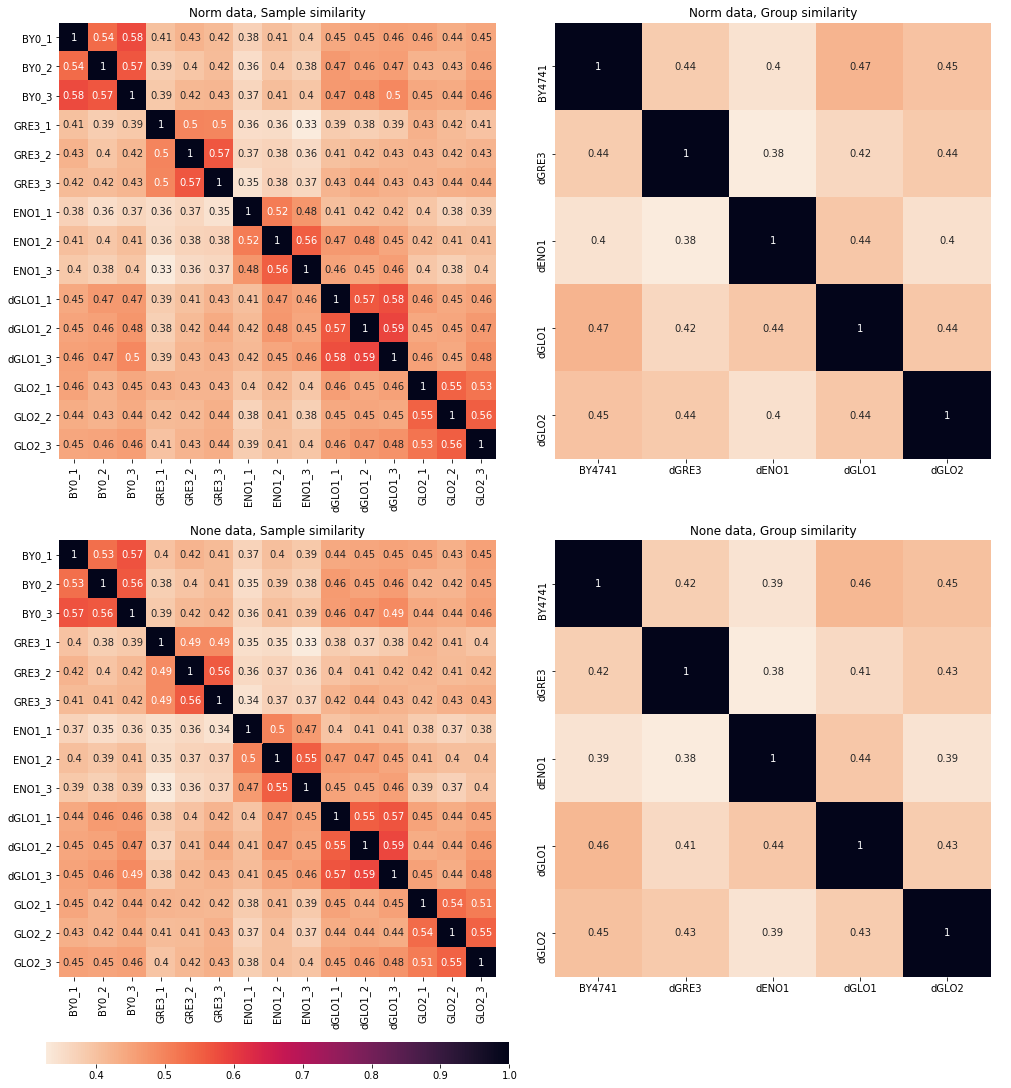

In [7]:
sim_norm = mz_similarity(yeast_norm_nan, has_labels=True)
sim_none = mz_similarity(yeast_none_nan, has_labels=True)

grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
f, ax = plt.subplots(3,2, figsize=(14, 15), gridspec_kw=grid_kws, constrained_layout=True)

hm = sns.heatmap(sim_norm.sample_similarity_jaccard, annot=True, square=True, ax=ax[0][0], cmap=sns.cm.rocket_r, cbar=None)
hm = sns.heatmap(sim_norm.label_similarity_jaccard, annot=True, square=True, ax=ax[0][1], cmap=sns.cm.rocket_r, cbar=None)
ax[0][0].set_title('Norm data, Sample similarity')
ax[0][1].set_title('Norm data, Group similarity')
hm = sns.heatmap(sim_none.sample_similarity_jaccard, annot=True, square=True, 
                                                     ax=ax[1][0], cmap=sns.cm.rocket_r,
                                                     cbar_ax=ax[2][0], cbar_kws={"orientation": "horizontal"})
hm = sns.heatmap(sim_none.label_similarity_jaccard, annot=True, square=True, ax=ax[1][1], cmap=sns.cm.rocket_r, cbar=None)
ax[1][0].set_title('None data, Sample similarity')
ax[1][1].set_title('None data, Group similarity')
ax[2][1].set_axis_off()
#f.tight_layout()

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [8]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

In [9]:
yeast_norm_01 = df_to_bool(yeast_norm_nan)
yeast_none_01 = df_to_bool(yeast_none_nan)

names = list(yeast_none_01.ms.samples)
scipy_jdist = dist.pdist(yeast_norm_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=names, columns=names)

jsim = sim_norm.sample_similarity_jaccard
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Yeast dendogram, Jaccard distance, Norm dataset


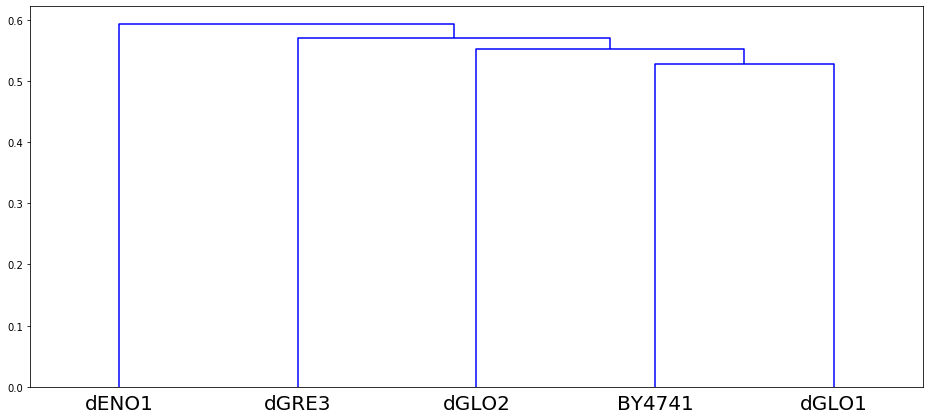

In [10]:
print('Yeast dendogram, Jaccard distance, Norm dataset')
jdist = dist.squareform(1 - sim_norm.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

names = list(yeast_norm_01.ms.unique_labels)

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=names, leaf_font_size=20, above_threshold_color='b')

In [11]:
print(hier.cophenet(Z,jdist)[0])

0.8141336262504134


### Non-binary Similarity Analysis


Set label colors for consistency in all plots

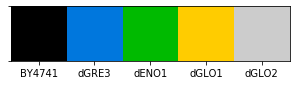

In [12]:
# may change in the future...
colours = cm.get_cmap('nipy_spectral', 5)(range(5))

labels = list(yeast_norm_nan.ms.unique_labels)

label_colors = {lbl: c for lbl, c in zip(labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(labels)), labels)

### Normalized MetaboScape Data (m/z delta = 1)

3 types of processing:

Imp_neg - MetScape Normalization, Missing Value Imputation.

P_norm - MetScape Normalization, Missing Value Imputation and Pareto Scaling.

NGP_norm - MetScape Normalization, Missing Value Imputation, glog transformation and Pareto Scaling.

Note: Starts without Leucine Enkephalin peak.

In [13]:
#Imp_norm 
Imp_norm = sca.NaN_Imputation(yeast_norm_nan, 0) #Substitute missing values with half of the minimum intensity.
#Imp_norm.data

Yeast dendrogram, Euclidean distance, MetScape Normalization and NaN Imputation


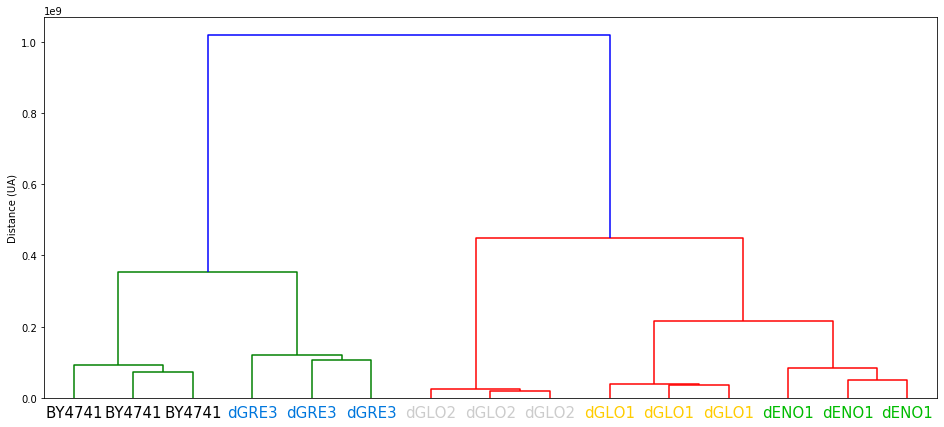

In [14]:
#Measure Euclidean distances
dist_Imp_norm = dist.pdist(Imp_norm.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, MetScape Normalization and NaN Imputation')
Z_Imp_norm = hier.linkage(dist_Imp_norm, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_Imp_norm, labels=Imp_norm.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [15]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_Imp_norm,dist_Imp_norm)[0]) #method average seems to lead to higher coefficients

0.9253713106371382


In [16]:
#P_norm
P_norm = sca.ParetoScal(Imp_norm)

Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation and Pareto Scaling


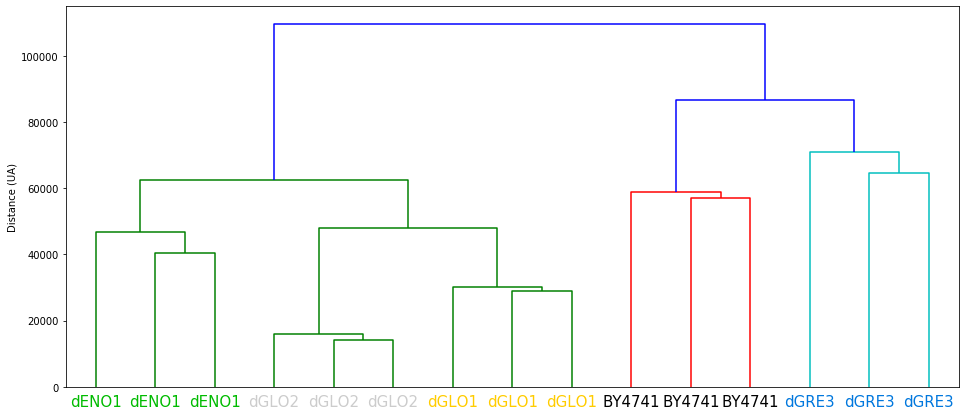

In [17]:
#Measure Euclidean distances
dist_P_norm = dist.pdist(P_norm.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation and Pareto Scaling')
Z_P_norm = hier.linkage(dist_P_norm, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_P_norm, labels=P_norm.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [18]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_P_norm,dist_P_norm)[0]) #method average seems to lead to higher coefficients

0.9491414827411592


In [19]:
#NGP_norm
glog_norm = sca.glog(Imp_norm)
NGP_norm = sca.ParetoScal(glog_norm)

Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation, Transformed and Pareto Scaling


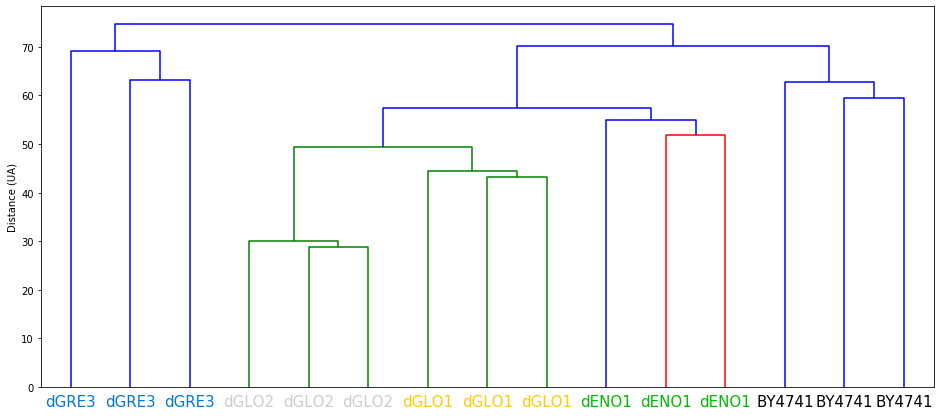

In [20]:
#Measure Euclidean distances
dist_NGP_norm = dist.pdist(NGP_norm.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation, Transformed and Pareto Scaling')
Z_NGP_norm = hier.linkage(dist_NGP_norm, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_NGP_norm, labels=NGP_norm.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [21]:
print(hier.cophenet(Z_NGP_norm,dist_NGP_norm)[0]) 

0.9778278211596627


### Binary Similarity Analysis Methods - Example Dendrogram

In [22]:
aligned_norm = df_to_bool(yeast_norm_nan)

Yeast dendrogram, Binary methods, Normalized by MetScape


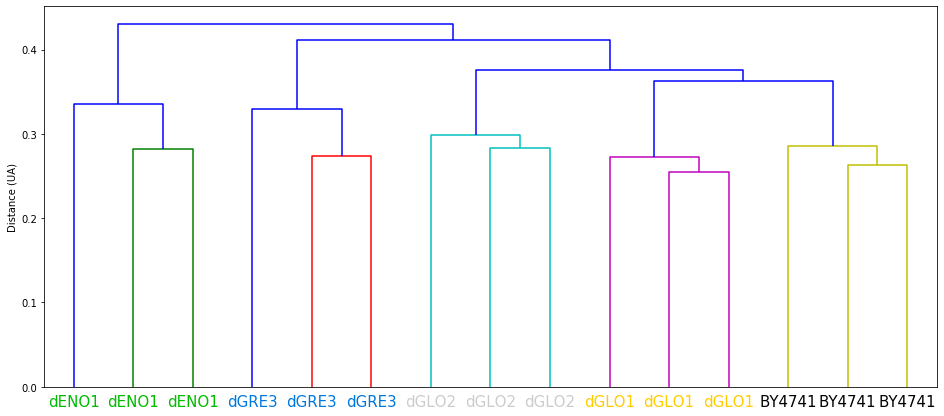

In [23]:
#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice_neg = hier.linkage(aligned_norm.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=yeast_norm_nan.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Not-normalized MetaboScape Data

4 types of processing:

Imp_none - Missing Value Imputation

P_none - Missing Value Imputation and Pareto Scaling.

NP_none - Missing Value Imputation, Normalization by a reference feature (Leucine Enkephalin) and Pareto Scaling.

NGP_none - Missing Value Imputation, Normalization by a reference feature (Leucine Enkephalin), glog transformation and Pareto Scaling.

Note: Leucine Enkephalin peak was taken out when Normalization happened.

In [24]:
#Imp_none
Imp_none = sca.NaN_Imputation(yeast_none_nan, 0)

Yeast dendrogram, Euclidean distance, NaN Imputation


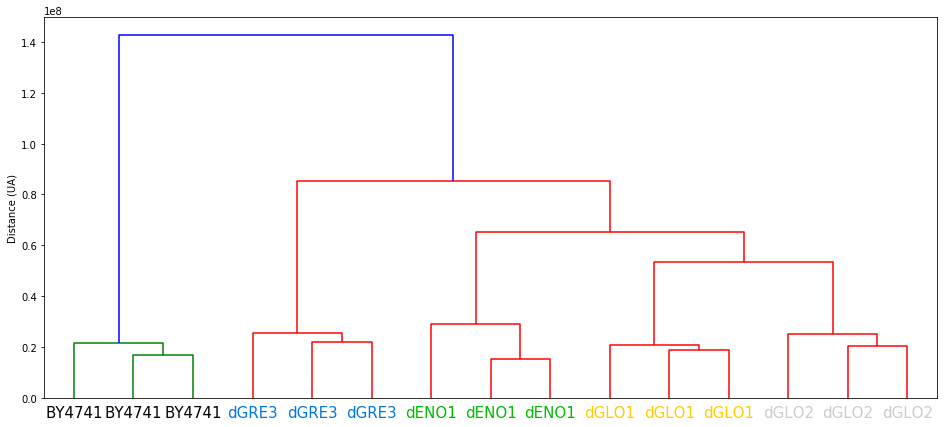

In [25]:
#Measure Euclidean distances
dist_Imp_none = dist.pdist(Imp_none.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation')
Z_Imp_none = hier.linkage(dist_Imp_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_Imp_none, labels=Imp_none.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [26]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_Imp_none,dist_Imp_none)[0]) #method average seems to lead to higher coefficients

0.9561765007392841


In [27]:
#P_none
P_none = sca.ParetoScal(Imp_none)

Yeast dendrogram, Euclidean distance, NaN Imputation and Pareto Scaling


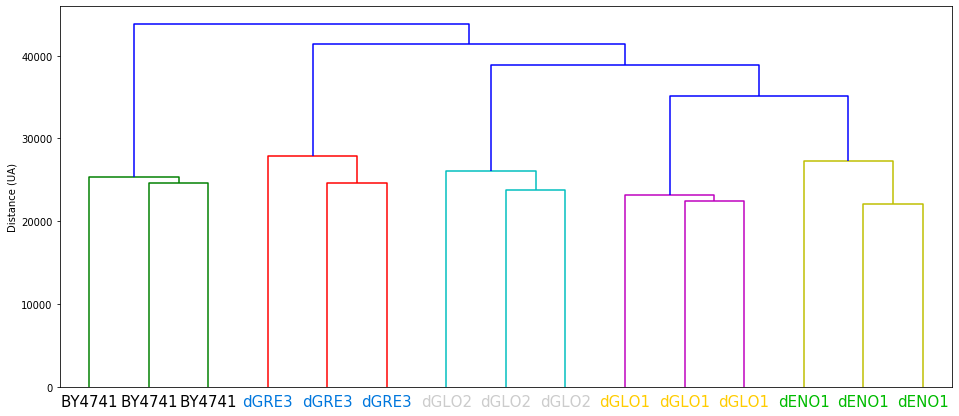

In [28]:
#Measure Euclidean distances
dist_P_none = dist.pdist(P_none.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation and Pareto Scaling')
Z_P_none = hier.linkage(dist_P_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_P_none, labels=P_none.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [29]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_P_none,dist_P_none)[0]) #method average seems to lead to higher coefficients

0.9255974599455183


In [30]:
#NP_none
Norm_none = sca.Norm_Feat(Imp_none, leu_enk_name)
NP_none = sca.ParetoScal(Norm_none)

Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized and Pareto Scaling


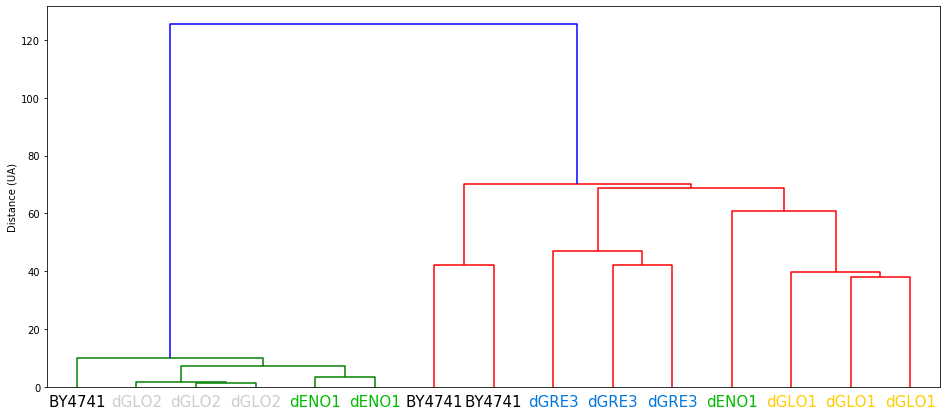

In [31]:
#Measure Euclidean distances
dist_NP_none = dist.pdist(NP_none.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized and Pareto Scaling')
Z_NP_none = hier.linkage(dist_NP_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_NP_none, labels=NP_none.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [32]:
print(hier.cophenet(Z_NP_none,dist_NP_none)[0]) 

0.9868669618372949


In [33]:
#NGP_none
glog_none = sca.glog(Norm_none)
NGP_none = sca.ParetoScal(glog_none)

Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized, Transformed and Pareto Scaling


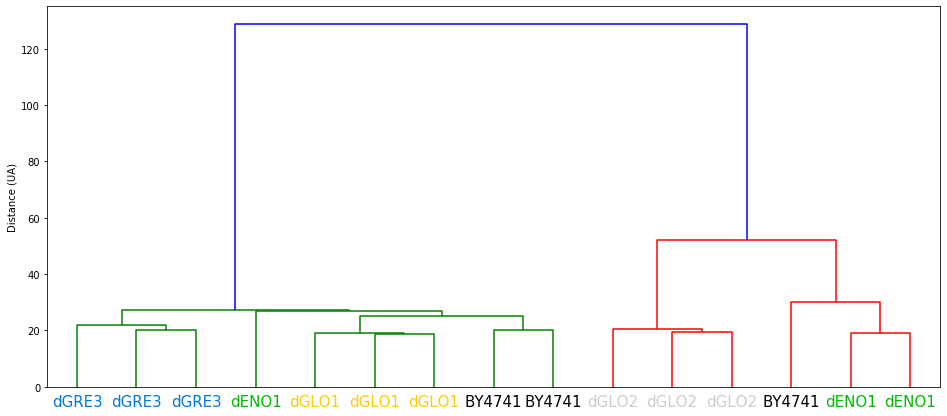

In [34]:
#Measure Euclidean distances
dist_NGP_none = dist.pdist(NGP_none.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_NGP_none = hier.linkage(dist_NGP_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_NGP_none, labels=NGP_none.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [35]:
print(hier.cophenet(Z_NGP_none,dist_NGP_none)[0]) 

0.9516397271677778


### Binary Similarity Analysis Methods - Example Dendrogram

In [36]:
aligned_none = df_to_bool(yeast_none_nan)

Yeast dendrogram, Binary methods, Not-Normalized by MetScape


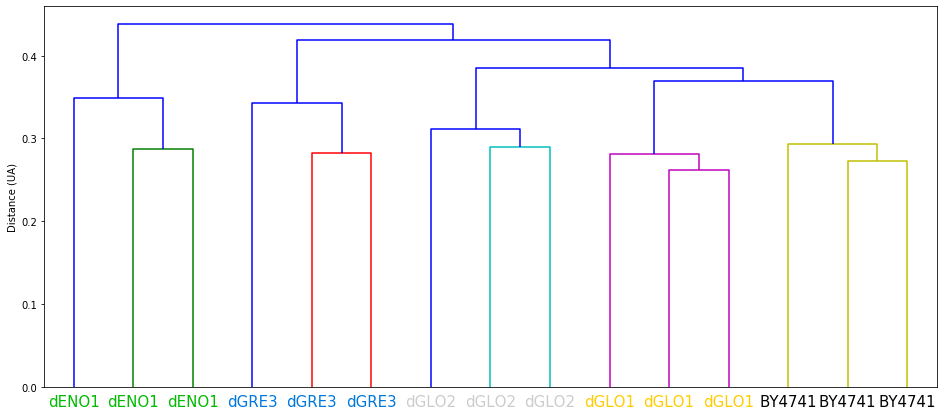

In [37]:
#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

print('Yeast dendrogram, Binary methods, Not-Normalized by MetScape')
Zdice_neg = hier.linkage(aligned_none.T, metric = 'dice', method ='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=yeast_none_nan.ms.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Comparing Dendrograms

#### Two methods: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [38]:
euclidean = (Z_Imp_norm, Z_P_norm, Z_NGP_norm, Z_Imp_none, Z_P_none, Z_NP_none, Z_NGP_none)
dist_euclidean = (dist_Imp_norm, dist_P_norm, dist_NGP_norm, dist_Imp_none, dist_P_none, dist_NP_none, dist_NGP_none)

#euclidean = (Z_Imp_none, Z_P_none, Z_NP_none, Z_NGP_none)
#dist_euclidean = (dist_Imp_none, dist_P_none, dist_NP_none, dist_NGP_none)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [39]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Imp_norm-P_norm   \t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp_norm-_NGP_norm\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Imp_norm-P_norm   	 0.7920505396156882 	 2.587411368337444e-43
Imp_norm-_NGP_norm	 0.524947529104374 	 1.5116315686103824e-20


According to the explanation given in the R package dendextend

In [40]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Imp_norm-P_norm   \t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp_norm-_NGP_norm\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Imp_norm-P_norm   	 0.9093678046304186 	 3.5736583585311486e-81
Imp_norm-_NGP_norm	 0.6377481669796734 	 2.2572148774456796e-25


#### Cophenetic Correlation Coefficient

In [41]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Imp_norm-P_norm   \t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp_norm-_NGP_norm\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Imp_norm-P_norm   	 0.9103218453518863 	 2.983812032298868e-41
Imp_norm-_NGP_norm	 0.713225873893961 	 1.3870526513170369e-17


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [42]:
# 9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
# 3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
binary = ( 'jaccard', 'hamming', 'yule')

In [43]:
# Application of all "single" steps needed presented in the examples above with distance metrics.
# Normalized by Metaboscape first
Z_norm = []
K_norm = []
S_norm = []
Coph_norm = []

for i in range(len(binary)):
    Z_norm.append(hier.linkage(aligned_norm.T, metric = binary[i], method='average')) #Z
    K_norm.append(ma.mergerank(Z_norm[i])) #Mergerank
    S_norm.append(K_norm[i][K_norm[i]!=0]) #Eliminating 0's
    Coph_norm.append(hier.cophenet(Z_norm[i], dist.pdist(aligned_norm.T, metric = binary[i]))) #Cophenetic

In [44]:
# Not Normalized dataset
Z_none = []
K_none = []
S_none = []
Coph_none = []

for i in range(len(binary)):
    Z_none.append(hier.linkage(aligned_none.T, metric = binary[i], method='average')) #Z
    K_none.append(ma.mergerank(Z_none[i])) #Mergerank
    S_none.append(K_none[i][K_none[i]!=0]) #Eliminating 0's
    Coph_none.append(hier.cophenet(Z_none[i], dist.pdist(aligned_none.T, metric = binary[i]))) #Cophenetic

In [45]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
# Norm Conventional, None Conventional, Norm Binaries, None Binaries
S = []
S.extend(S_BG)
S.extend(S_norm)#
S.extend(S_none)

# Creation of a list with all the returns from the function cophenetic for the different metrics: 
# Norm Conventional, None Conventional, Norm Binaries, None Binaries
Coph = []
Coph.extend(Coph_C)
Coph.extend(Coph_norm)#
Coph.extend(Coph_none)

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [46]:
#Column names and row names for the dataframes
colnames = ['Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none', 'NGP_none', 'jaccard_norm', 'hamming_norm',
            'yule_norm', 'jaccard_none', 'hamming_none', 'yule_none']
#colnames = ['Imp_none', 'P_none', 'NP_none', 'NGP_none', 'jaccard_none', 'hamming_none', 'yule_none']            
            #'dice_norm', 'hamming_norm',
            #'jaccard_norm', 'rogerstanimoto_norm', 'sokalmichener_norm', 'sokalsneath_norm','yule_norm', 'kulsinski_norm', 
            #'russellrao_norm','dice_none', 'hamming_none', 'jaccard_none', 'rogerstanimoto_none', 
            #'sokalmichener_none', 'sokalsneath_none', 'yule_none', 'kulsinski_none', 'russellrao_none']

In [47]:
nS = len(S)
df_K = pd.DataFrame(np.zeros((nS,nS)), columns=colnames, index=colnames) # K - Kendall (Baker)
df_S = pd.DataFrame(np.zeros((nS,nS)), columns=colnames, index=colnames) # S - Spearman (Baker)
df_C = pd.DataFrame(np.zeros((nS,nS)), columns=colnames, index=colnames) # C - Cophenetic Correlation
df_K_p = pd.DataFrame(np.zeros((nS,nS)), columns=colnames, index=colnames) # p-values of K method
df_S_p = pd.DataFrame(np.zeros((nS,nS)), columns=colnames, index=colnames) # p-values of S method
df_C_p = pd.DataFrame(np.zeros((nS,nS)), columns=colnames, index=colnames) # p-values of C method

In [49]:
#Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        df_K.iloc[i,j] = stats.kendalltau(S[i],S[j])[0] #Correlation coefficient
        df_S.iloc[i,j] = stats.spearmanr(S[i],S[j])[0] #Correlation coefficient
        df_C.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[0] #Correlation coefficient
        df_K_p.iloc[i,j] = stats.kendalltau(S[i],S[j])[1] #p-value
        df_S_p.iloc[i,j] = stats.spearmanr(S[i],S[j])[1] #p-value
        df_C_p.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[1] #p-value

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,7:]], axis = 1)
df_KI = pd.concat([df_K.iloc[:7], line, df_K.iloc[7:]])
df_KI = pd.concat([df_KI.iloc[:,:7], lineV.T, df_KI.iloc[:,7:]], axis = 1)
df_SI = pd.concat([df_S.iloc[:7], line, df_S.iloc[7:]])
df_SI = pd.concat([df_SI.iloc[:,:7], lineV.T, df_SI.iloc[:,7:]], axis = 1)
df_CI = pd.concat([df_C.iloc[:7], line, df_C.iloc[7:]])
df_CI = pd.concat([df_CI.iloc[:,:7], lineV.T, df_CI.iloc[:,7:]], axis = 1)
#line = pd.DataFrame(np.empty((1,10))* np.nan, columns = ['Imp_none', 'P_none', 'NP_none', 'NGP_none', 'jaccard_norm', 'hamming_norm',
            #'yule_norm', 'jaccard_none', 'hamming_none', 'yule_none'], index=[''])
#lineV = pd.concat([line.iloc[:,:4], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,4:]], axis = 1)
#df_CI = pd.concat([df_C.iloc[3:7, 3:], line, df_C.iloc[10:,3:]])
#df_CI = pd.concat([df_CI.iloc[:,:4], lineV.T, df_CI.iloc[:,4:]], axis = 1)

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


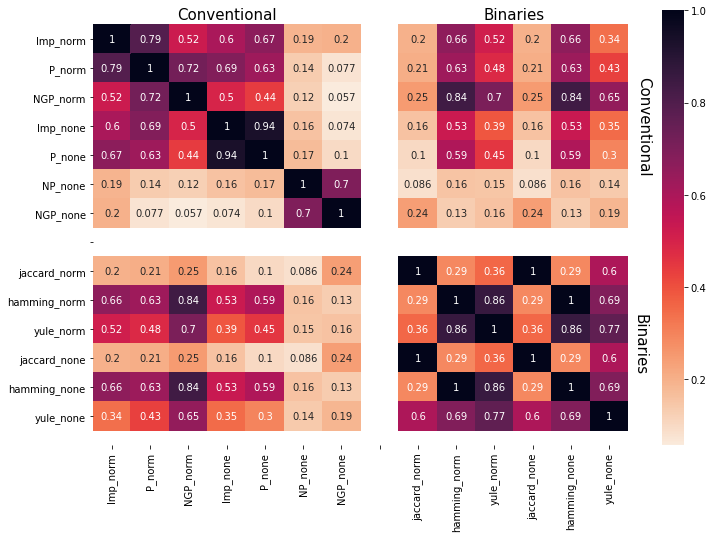

In [50]:
f, ax = plt.subplots(figsize=(12, 8))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3.5,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(14.2,3.5,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(11,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(14.1,11,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


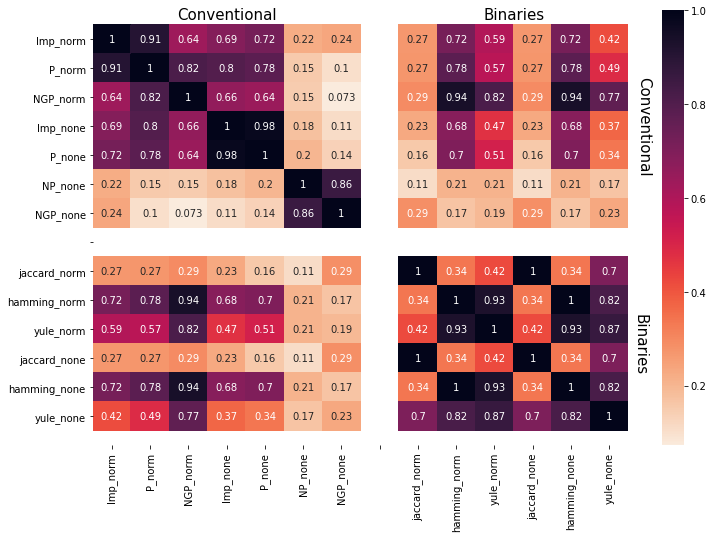

In [51]:
f, ax = plt.subplots(figsize=(12, 8))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3.5,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(14.2,3.5,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(11,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(14.1,11,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


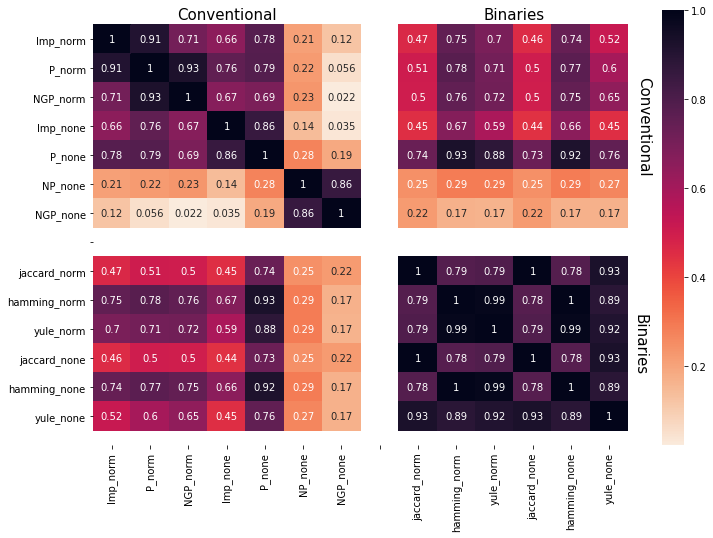

In [52]:
f, ax = plt.subplots(figsize=(12, 8))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3.5,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(14.2,3.5,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(11,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(14.1,11,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: Norm Conventional, None Conventional, Norm Binary, None Binary)

In [53]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 4)
col_lbl2 = colours2(range(4))
for i in range(2):
    label_colors2[df_K.columns[3*i]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+1]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+2]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+3]] = col_lbl2[i]
for i in range(3):
    label_colors2[df_K.columns[7+i]] = col_lbl2[2]
    label_colors2[df_K.columns[10+i]] = col_lbl2[3]

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


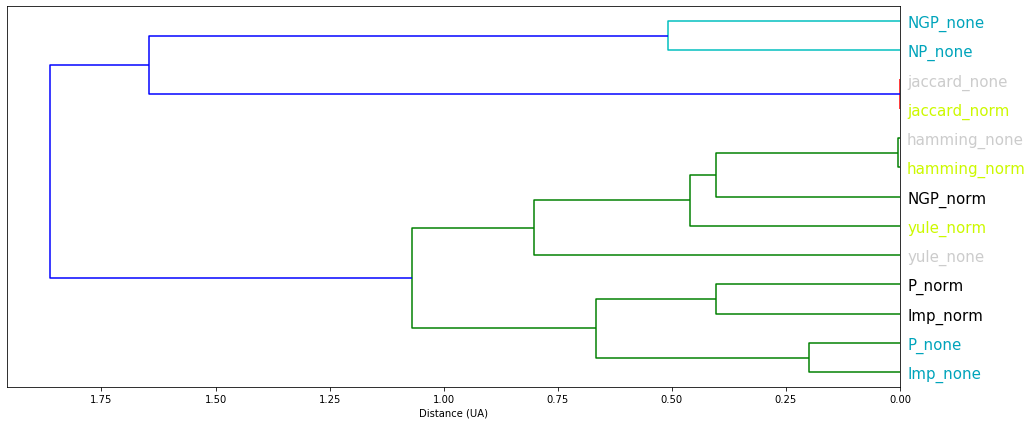

In [54]:
print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
Z_K = hier.linkage(df_K, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=df_K.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


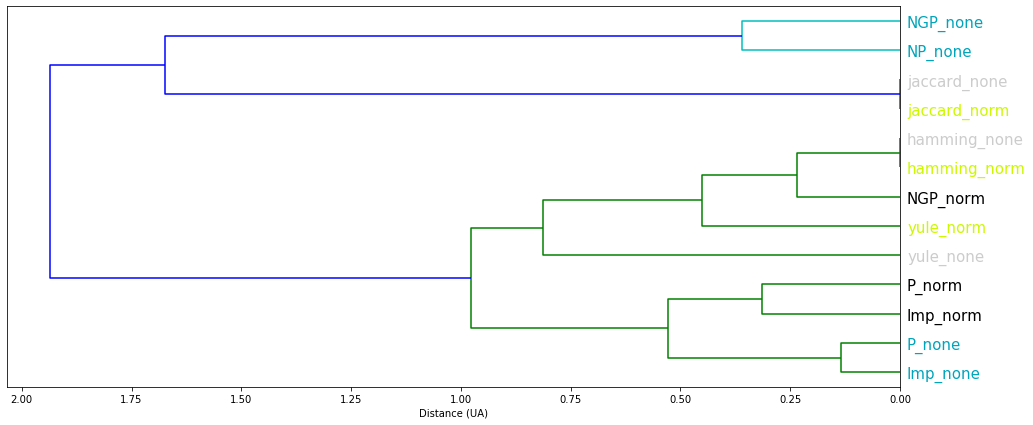

In [55]:
print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
Z_S = hier.linkage(df_S, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=df_S.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


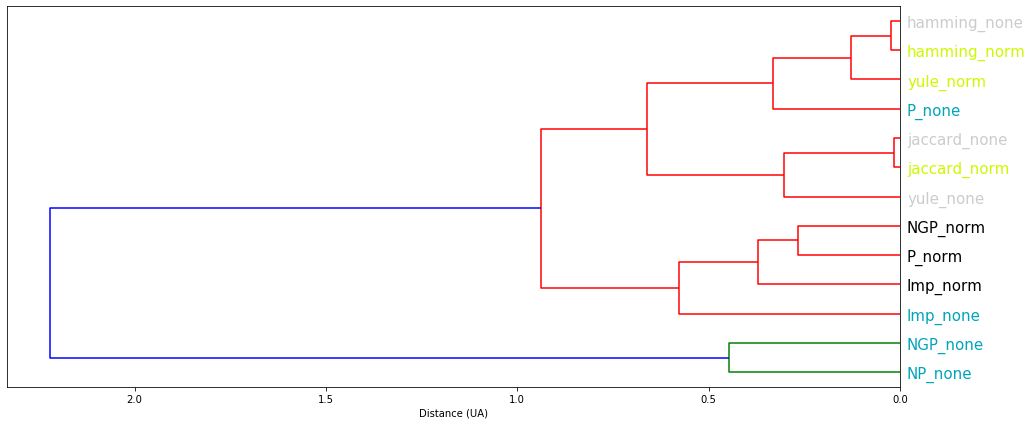

In [56]:
print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
Z_C = hier.linkage(df_C, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=df_C.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [57]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_norm)
Z.extend(Z_none)

In [58]:
disc_average = np.zeros((1,13))
disc_median = np.zeros((1,13))
disc_correct = np.zeros((1,13))
for i in range(len(Z)):
    discrim = sca.dist_discrim(yeast_norm_nan, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(yeast_norm_nan, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,7:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,7:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,7:]], axis = 1)

Text(10.6, -0.2, 'Binaries')

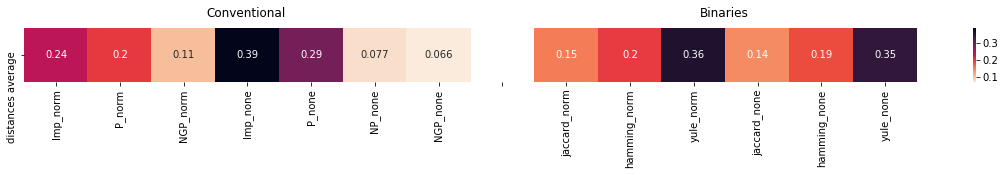

In [59]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(2.85,-0.2,'Conventional', fontsize  = 12)
plt.text(10.6,-0.2,'Binaries', fontsize = 12)

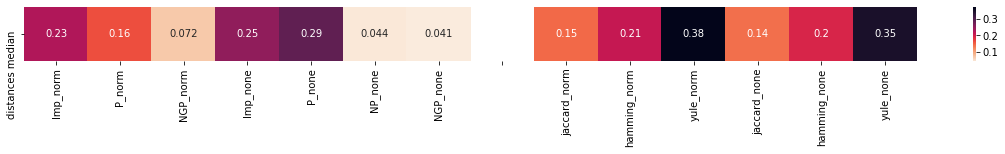

In [60]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

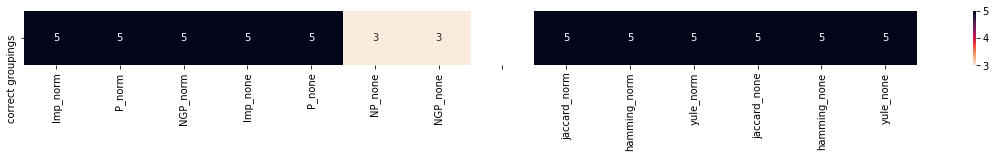

In [61]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [62]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [63]:
Kmean = skclust.KMeans(n_clusters=5)

In [64]:
a = Kmean.fit(NGP_none.T)

In [65]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(yeast_norm_nan.ms.labels[i])
    else:
        dicto[a.labels_[i]] = [yeast_norm_nan.ms.labels[i]]
dicto

{2: ['BY4741'],
 0: ['BY4741', 'BY4741', 'dENO1', 'dGLO1', 'dGLO1', 'dGLO1'],
 3: ['dGRE3', 'dGRE3', 'dGRE3'],
 4: ['dENO1', 'dENO1'],
 1: ['dGLO2', 'dGLO2', 'dGLO2']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [66]:
colnames2 = ['Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none','NGP_none', 'binary_norm','binary_none']

In [67]:
euclidean = (Imp_norm, P_norm, NGP_norm, Imp_none, P_none, NP_none, NGP_none)
binaries = (aligned_norm, aligned_none)

In [68]:
disc_average = np.zeros((1,9))
disc_median = np.zeros((1,9))
disc_correct = np.zeros((1,9))
for i in range(len(euclidean)):
    discrim = ma.Kmeans_discrim(euclidean[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(euclidean[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
for i in range(len(binaries)):
    discrim = ma.Kmeans_discrim(binaries[i], method = 'average')
    disc_average[0,7 + i] 
    disc_average[0,7 + i] = discrim[0]
    disc_median[0,7 + i] = ma.Kmeans_discrim(binaries[i], method = 'median')[0] 
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,7 + i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

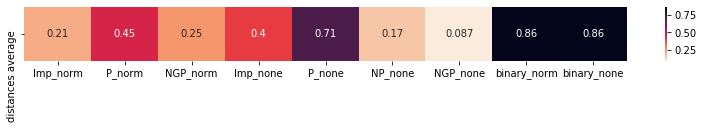

In [69]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)

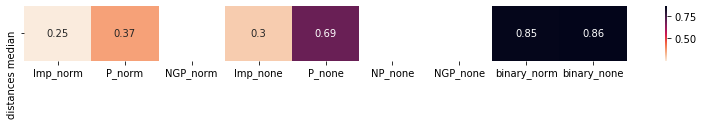

In [70]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

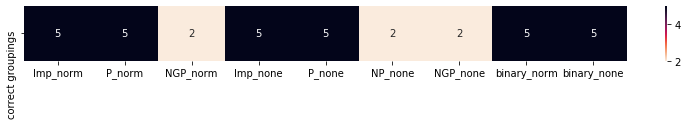

In [71]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

In [72]:
#Creation of "binary" Spectras using the binary matrices built with the function df_to_bool.
binary_norm = aligned_norm.copy()
binary_none = aligned_none.copy()

In [73]:
euclidean = (Imp_norm, P_norm, NGP_norm, binary_norm, Imp_none, P_none, NP_none, NGP_none)
binaries = (aligned_norm, aligned_none)
colnames2 = ['Imp_norm', 'P_norm', 'NGP_norm', 'binary_norm','Imp_none', 'P_none', 'NP_none','NGP_none','binary_none']

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [74]:
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,150,10)

In [75]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [76]:
param = []
test_score = []
for i in range(len(euclidean)):
    clf.fit(euclidean[i].T, euclidean[i].ms.labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
for i in range(len(binaries)):
    clf.fit(binaries[i].T, yeast_norm_nan.ms.labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])

Performance based on number of trees - Alignment: None, Positive Mode


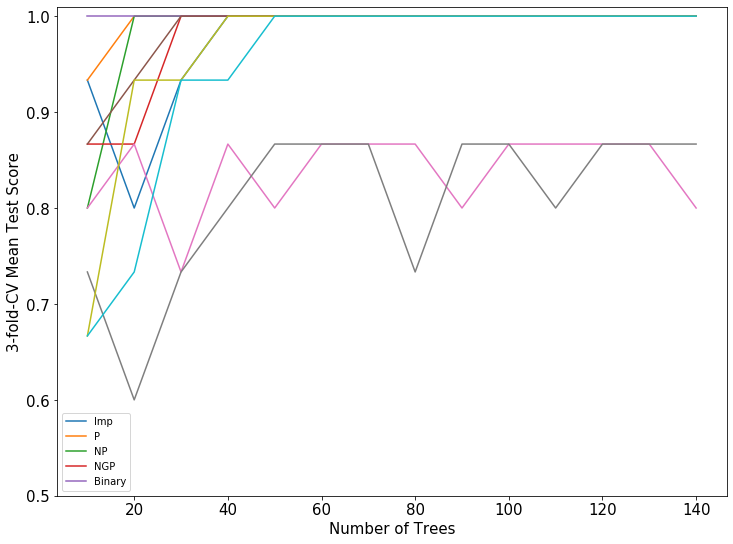

In [77]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(len(param)):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
plt.ylim([0.5,1.01])
ax.legend(['Imp','P', 'NP','NGP','Binary'])
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: None, Positive Mode')

#### Applications of different methods

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated 20 times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function simple_RF from multianalysis.

In [ ]:
# Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

all_data = (Imp_norm, P_norm, NGP_norm, Imp_none, P_none, NP_none, NGP_none, binary_norm, binary_none)
names = ('Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none', 'NGP_none', 'binary_norm', 'binary_none')
for name, data in zip(names, all_data):
    rf = ma.simple_RF(data)
    #, iter_num = 100) #(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
    Scores[name] = rf[0]
    Scores_std[name] = np.std(rf[0])
    Imp_feat[name] = rf[1]
    print(f'random forest for {name} created')    

### Attempt/Method nº2 - SMOTE -  NOT APPLIED SO FAR - Code in Markdown

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function fast_SMOTE from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

### Results of the Random Forests sumarised in Heatmaps


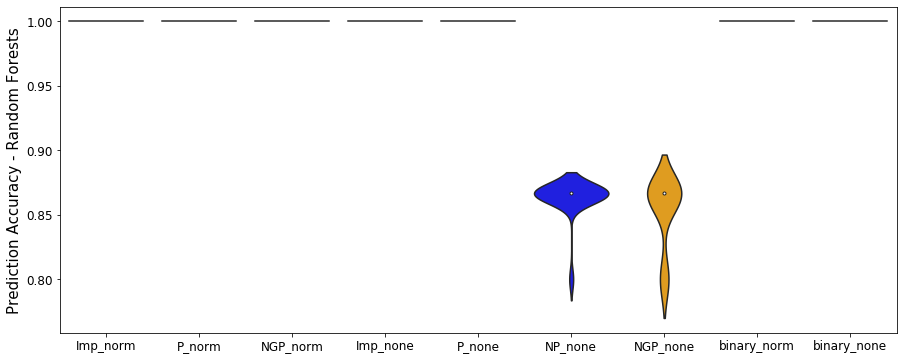

In [82]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','green','red','purple','blue','orange','green','red']
data = pd.DataFrame.from_dict(Scores)
sns.violinplot(data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forests', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)

In [87]:
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

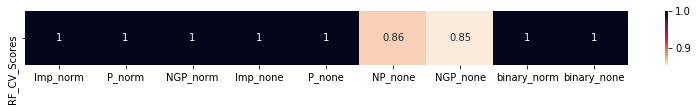

In [88]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

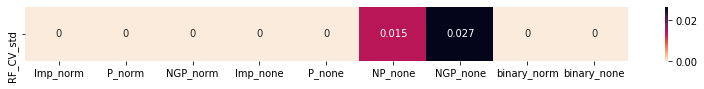

In [89]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [90]:
Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys(), columns = ['Accuracy']).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_A.keys()).T
Scores_ic = Scores_std_H / (100**0.5)*1.96

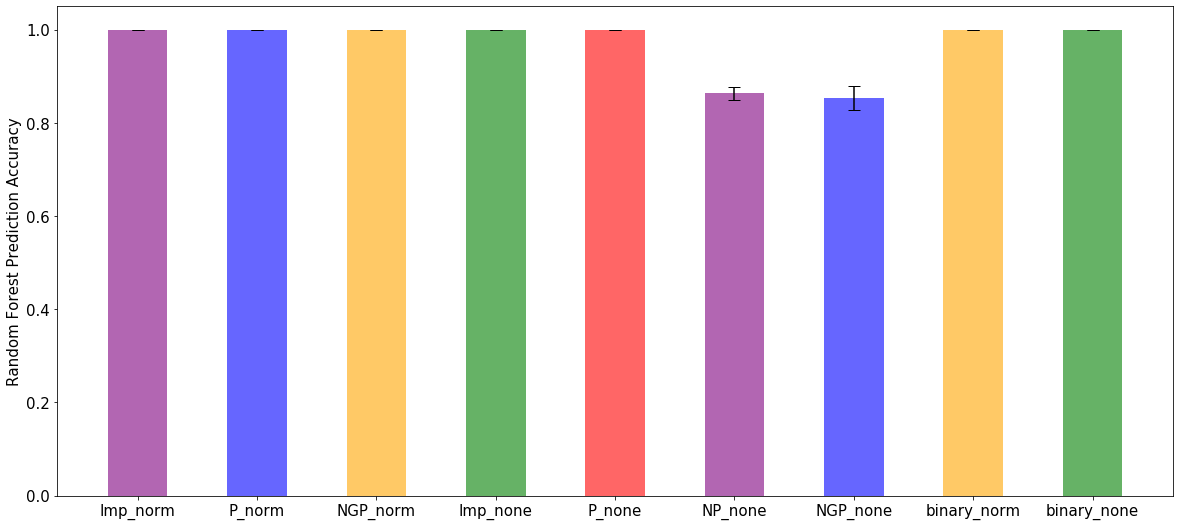

In [91]:
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
color = ['purple','blue','orange','green','red']
plt.bar(height = Scores_H.T['Accuracy'], x = Scores_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Scores_H.columns, y = Scores_H.T['Accuracy'], yerr = Scores_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [92]:
# Getting the number of samples, groups, ratios for each important feature,
# magnitude for most important feature and % explained by these features (more)

ev = []
magni = []
more = []
for j in Imp_feat:#['neg2-1_direct']:
    if j.endswith('norm'):
        Spectra = yeast_norm_nan
    elif j.endswith('none'):
        Spectra = yeast_none_nan
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    magni.append(Imp_feat[j][0][1]/(1/len(Spectra)))
    a = 0
    for i in range(number): 
        a = a + Imp_feat[j][i][1]*100 
        ngroups = {}
        line = Spectra.loc[Imp_feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.ms.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [93]:
# Calculate averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Imp_feat])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([line, df.iloc[0:3],line, df.iloc[3:7],line, df.iloc[7:]])

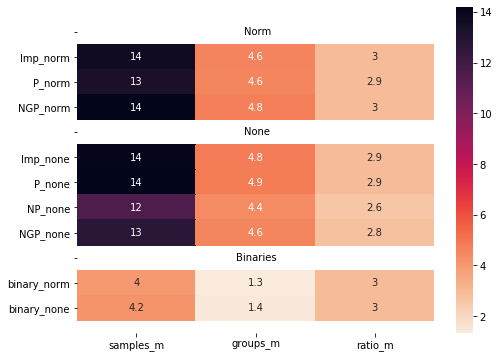

In [94]:
f, ax = plt.subplots(figsize=(8, 6))
mask = df.isnull()
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r, mask = mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.4,0.6,'Norm')
plt.text(1.4,4.6,'None')
plt.text(1.34,9.6,'Binaries')
plt.show()

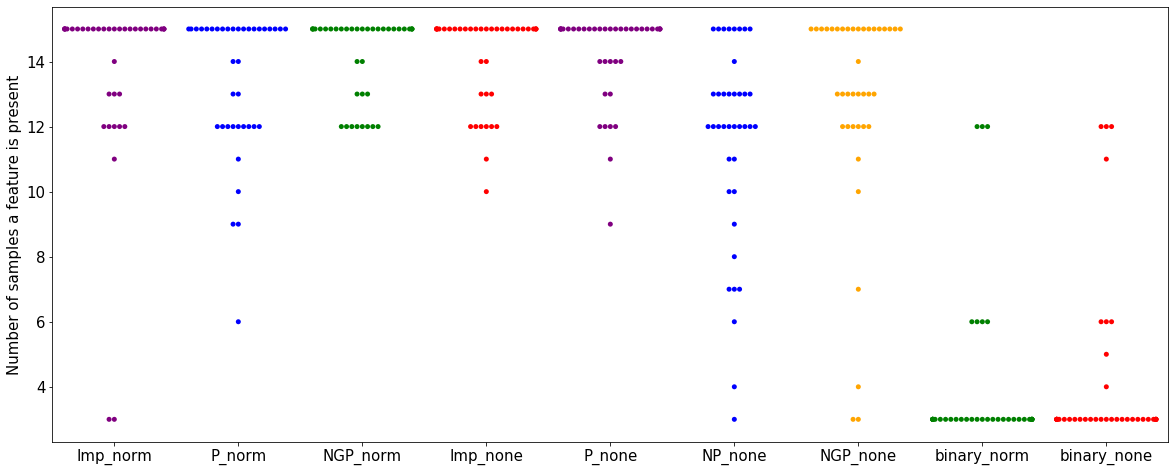

In [95]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 5, palette = ['purple','blue','green','red','purple','blue','orange','green','red'])
ax.set(xticklabels = [list(Imp_feat.keys())[i][0:13] for i in range(len(Imp_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [96]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [4.3904718308395765, 4.237366312742893, 4.189343958071183, 4.557151335310876, 4.333063961830409, 5.302704796107318, 5.211683299599035, 5.318792666467971, 5.915513228187352]
% of model explained by the 2% most important features [6.8841714296332785, 6.886275359348751, 6.833983352408194, 7.129976798583874, 7.226589637648239, 6.486634505754131, 6.468221486951738, 8.556202664859203, 8.356023311194066]


### Extracting a single decision tree

Decision Tree


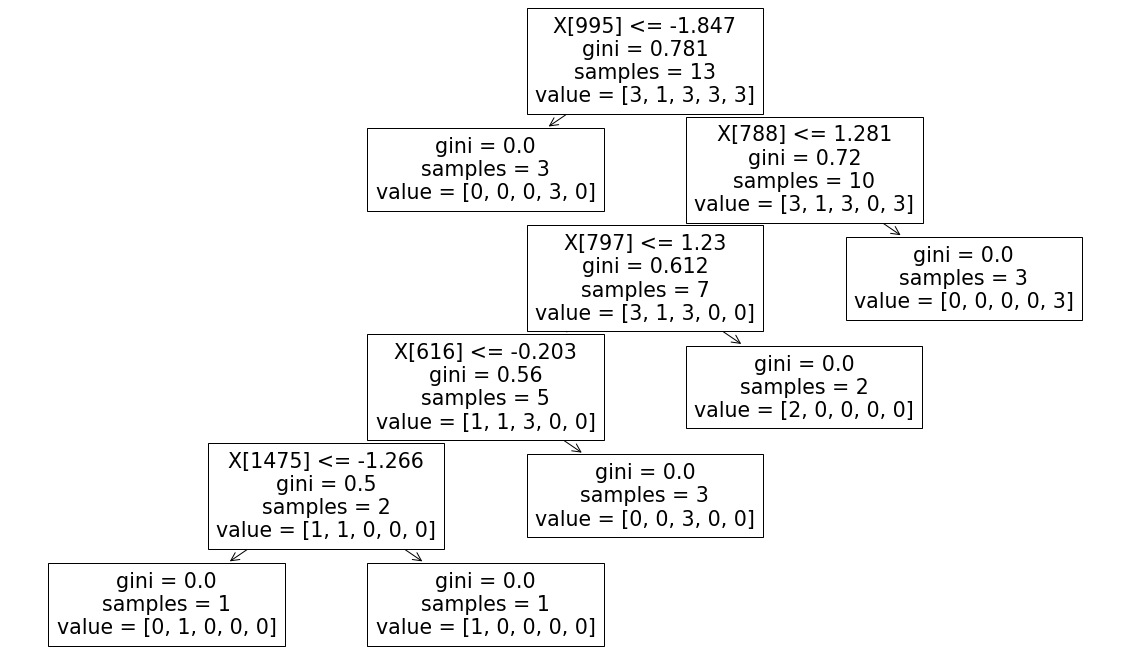

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(NGP_none.T, NGP_none.ms.labels, test_size=0.1)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
rf.fit(X_train, y_train)

from sklearn import tree
fig = plt.figure(figsize=(20,12))
clf = rf.estimators_[2].fit(X_train, y_train)
tree.plot_tree(clf)
print('Decision Tree')

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [98]:
matrix = pd.get_dummies(yeast_norm_nan.ms.labels)
unique_labels = list(yeast_norm_nan.ms.unique_labels)
matrix = matrix[unique_labels]

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 30 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [99]:
%%capture
#PLS applied in the MetScape Normalized Dataset.
Imp_norm_PLS = ma.optim_PLS(Imp_norm, matrix, max_comp = 30)
P_norm_PLS = ma.optim_PLS(P_norm, matrix, max_comp = 30)
NGP_norm_PLS = ma.optim_PLS(NGP_norm, matrix, max_comp = 30)
bin_norm_PLS = ma.optim_PLS(binary_norm, matrix, max_comp = 30)

#PLS applied in the non-MetScape Normalized Dataset.
Imp_none_PLS = ma.optim_PLS(Imp_none, matrix, max_comp = 30)
P_none_PLS = ma.optim_PLS(P_none, matrix, max_comp = 30)
NP_none_PLS = ma.optim_PLS(NP_none, matrix, max_comp = 30)
NGP_none_PLS = ma.optim_PLS(NGP_none, matrix, max_comp = 30)
bin_none_PLS = ma.optim_PLS(binary_none, matrix, max_comp = 30)

Performance based on number of components - Normalized Mode


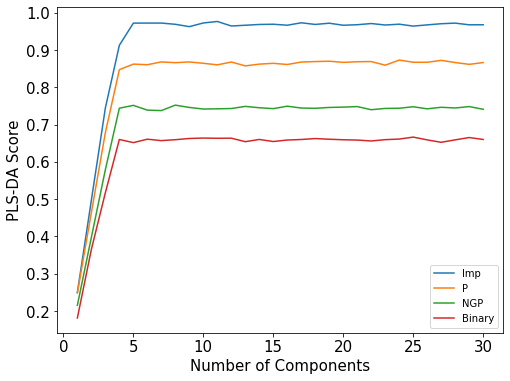

In [100]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_norm_PLS[0])
plt.plot(range(1,31),P_norm_PLS[0])
plt.plot(range(1,31),NGP_norm_PLS[0])
plt.plot(range(1,31),bin_norm_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of components - Normalized Mode')

Performance based on number of components - Normalized Mode


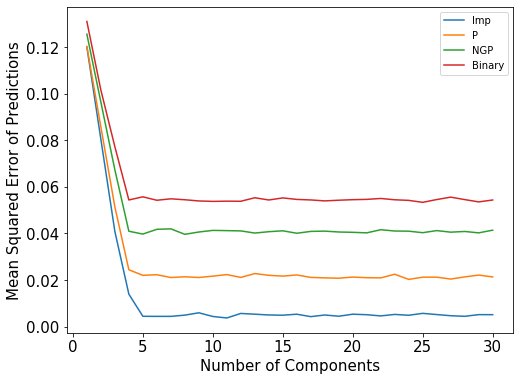

In [101]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_norm_PLS[2])
plt.plot(range(1,31),P_norm_PLS[2])
plt.plot(range(1,31),NGP_norm_PLS[2])
plt.plot(range(1,31),bin_norm_PLS[2])
plt.ylabel('Mean Squared Error of Predictions', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of components - Normalized Mode')

Performance based on number of components - Not-Normalized Mode


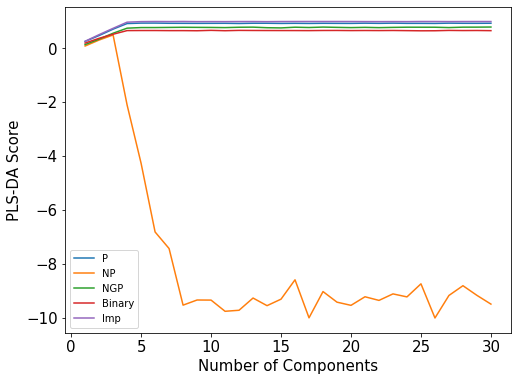

In [102]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),P_none_PLS[0])
plt.plot(range(1,31),NP_none_PLS[0])
plt.plot(range(1,31),NGP_none_PLS[0])
plt.plot(range(1,31),bin_none_PLS[0])
plt.plot(range(1,31),Imp_none_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('P', 'NP', 'NGP', 'Binary', 'Imp'))
print('Performance based on number of components - Not-Normalized Mode')

Performance based on number of components - Not-Normalized Mode


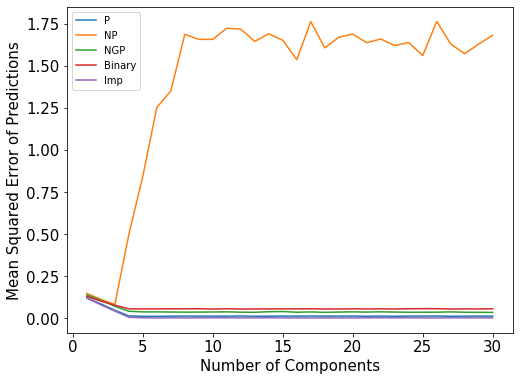

In [103]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),P_none_PLS[2])
plt.plot(range(1,31),NP_none_PLS[2])
plt.plot(range(1,31),NGP_none_PLS[2])
plt.plot(range(1,31),bin_none_PLS[2])
plt.plot(range(1,31),Imp_none_PLS[2])
plt.ylabel('Mean Squared Error of Predictions', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('P', 'NP', 'NGP', 'Binary', 'Imp'))
print('Performance based on number of components - Not-Normalized Mode')

### Application of PLS-DA

The number of components seemed to be converged when it reached around 4/5 so 6 components were used from now on. Also MSE is the inverse of the score given by the PLS function of the module scikit-learn so from now on we will only collect the score knowing its meaning.

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [104]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [105]:
%%capture
Imp_norm_PLS = ma.model_PLSDA(Imp_norm, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['Imp_norm'] = Imp_norm_PLS[0]
PLS_score['Imp_norm'] = Imp_norm_PLS[1]
PLS_Feat['Imp_norm'] = Imp_norm_PLS[3]

P_norm_PLS = ma.model_PLSDA(P_norm, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['P_norm'] = P_norm_PLS[0]
PLS_score['P_norm'] = P_norm_PLS[1]
PLS_Feat['P_norm'] = P_norm_PLS[3]

NGP_norm_PLS = ma.model_PLSDA(NGP_norm, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['NGP_norm'] = NGP_norm_PLS[0]
PLS_score['NGP_norm'] = NGP_norm_PLS[1]
PLS_Feat['NGP_norm'] = NGP_norm_PLS[3]

bin_norm_PLS = ma.model_PLSDA(binary_norm, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['bin_norm'] = bin_norm_PLS[0]
PLS_score['bin_norm'] = bin_norm_PLS[1]
PLS_Feat['bin_norm'] = bin_norm_PLS[3]

In [106]:
%%capture
Imp_none_PLS = ma.model_PLSDA(Imp_none, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['Imp_none'] = Imp_none_PLS[0]
PLS_score['Imp_none'] = Imp_none_PLS[1]
PLS_Feat['Imp_none'] = Imp_none_PLS[3]

P_none_PLS = ma.model_PLSDA(P_none, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['P_none'] = P_none_PLS[0]
PLS_score['P_none'] = P_none_PLS[1]
PLS_Feat['P_none'] = P_none_PLS[3]

NP_none_PLS = ma.model_PLSDA(NP_none, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['NP_none'] = NP_none_PLS[0]
PLS_score['NP_none'] = NP_none_PLS[1]
PLS_Feat['NP_none'] = NP_none_PLS[3]

NGP_none_PLS = ma.model_PLSDA(NGP_none, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['NGP_none'] = NGP_none_PLS[0]
PLS_score['NGP_none'] = NGP_none_PLS[1]
PLS_Feat['NGP_none'] = NGP_none_PLS[3]

bin_none_PLS = ma.model_PLSDA(binary_none, matrix, n_comp = 6, iter_num = 100, feat_type = 'Coef')
PLS_accu['bin_none'] = bin_none_PLS[0]
PLS_score['bin_none'] = bin_none_PLS[1]
PLS_Feat['bin_none'] = bin_none_PLS[3]

Accuracy based on the dataset


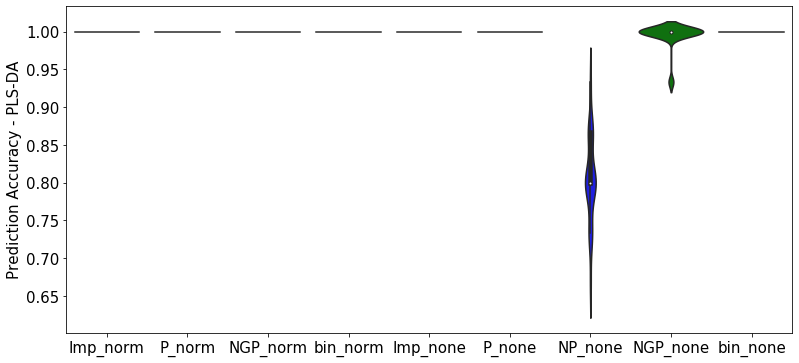

In [107]:
f, ax = plt.subplots(figsize=(13,6))
colors = ['purple','blue','orange','green','red','purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
print('Accuracy based on the dataset')

Performance score based on the dataset


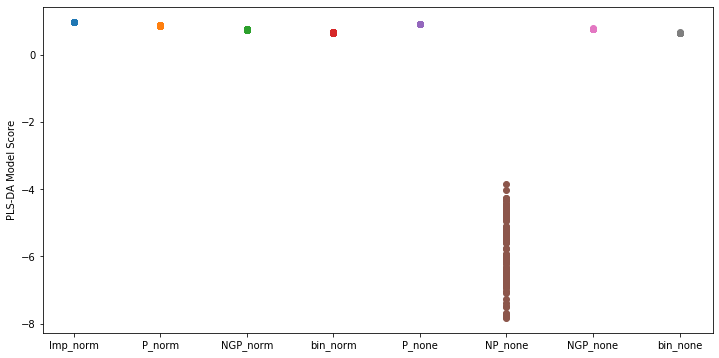

In [108]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['Imp_norm']*len(PLS_score['Imp_norm']), PLS_score['Imp_norm'])
plt.scatter(['P_norm']*len(PLS_score['P_norm']), PLS_score['P_norm'])
plt.scatter(['NGP_norm']*len(PLS_score['NGP_norm']), PLS_score['NGP_norm'])
plt.scatter(['bin_norm']*len(PLS_score['bin_norm']), PLS_score['bin_norm'])
plt.scatter(['P_none']*len(PLS_score['P_none']), PLS_score['P_none'])
plt.scatter(['NP_none']*len(PLS_score['NP_none']), PLS_score['NP_none'])
plt.scatter(['NGP_none']*len(PLS_score['NGP_none']), PLS_score['NGP_none'])
plt.scatter(['bin_none']*len(PLS_score['bin_none']), PLS_score['bin_none'])
plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset')

In [109]:
Accuracy = {}
Accuracy['Imp_norm'] = np.mean(PLS_accu['Imp_norm'])
Accuracy['P_norm'] = np.mean(PLS_accu['P_norm'])
Accuracy['NGP_norm'] = np.mean(PLS_accu['NGP_norm'])
Accuracy['bin_norm'] = np.mean(PLS_accu['bin_norm'])
Accuracy['Imp_none'] = np.mean(PLS_accu['Imp_none'])
Accuracy['P_none'] = np.mean(PLS_accu['P_none'])
Accuracy['NP_none'] = np.mean(PLS_accu['NP_none'])
Accuracy['NGP_none'] = np.mean(PLS_accu['NGP_none'])
Accuracy['bin_none'] = np.mean(PLS_accu['bin_none'])

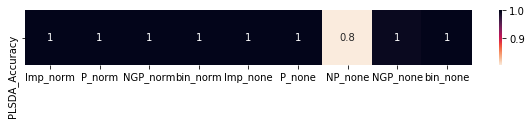

In [110]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [111]:
Score = {}
Score['Imp_norm'] = np.mean(PLS_score['Imp_norm'])
Score['P_norm'] = np.mean(PLS_score['P_norm'])
Score['NGP_norm'] = np.mean(PLS_score['NGP_norm'])
Score['bin_norm'] = np.mean(PLS_score['bin_norm'])
Score['Imp_none'] = np.mean(PLS_score['Imp_none'])
Score['P_none'] = np.mean(PLS_score['P_none'])
Score['NP_none'] = np.mean(PLS_score['NP_none'])
Score['NGP_none'] = np.mean(PLS_score['NGP_none'])
Score['bin_none'] = np.mean(PLS_score['bin_none'])

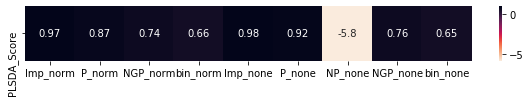

In [112]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [113]:
Accuracy_std = {}
Accuracy_std['Imp_norm'] = np.std(PLS_accu['Imp_norm'])
Accuracy_std['P_norm'] = np.std(PLS_accu['P_norm'])
Accuracy_std['NGP_norm'] = np.std(PLS_accu['NGP_norm'])
Accuracy_std['bin_norm'] = np.std(PLS_accu['bin_norm'])
Accuracy_std['Imp_none'] = np.std(PLS_accu['Imp_none'])
Accuracy_std['P_none'] = np.std(PLS_accu['P_none'])
Accuracy_std['NP_none'] = np.std(PLS_accu['NP_none'])
Accuracy_std['NGP_none'] = np.std(PLS_accu['NGP_none'])
Accuracy_std['bin_none'] = np.std(PLS_accu['bin_none'])

In [114]:
Score_std = {}
Score_std['Imp_norm'] = np.std(PLS_score['Imp_norm'])
Score_std['P_norm'] = np.std(PLS_score['P_norm'])
Score_std['NGP_norm'] = np.std(PLS_score['NGP_norm'])
Score_std['bin_norm'] = np.std(PLS_score['bin_norm'])
Score_std['Imp_none'] = np.std(PLS_score['Imp_none'])
Score_std['P_none'] = np.std(PLS_score['P_none'])
Score_std['NP_none'] = np.std(PLS_score['NP_none'])
Score_std['NGP_none'] = np.std(PLS_score['NGP_none'])
Score_std['bin_none'] = np.std(PLS_score['bin_none'])

In [115]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
Imp_norm,1.000000,0.000000
P_norm,1.000000,0.000000
NGP_norm,1.000000,0.000000
bin_norm,1.000000,0.000000
Imp_none,1.000000,0.000000
P_none,1.000000,0.000000
NP_none,0.804667,0.056769
NGP_none,0.995333,0.017010
bin_none,1.000000,0.000000


In [116]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
Imp_norm,0.969583,0.003443
P_norm,0.866866,0.003801
NGP_norm,0.744616,0.003809
bin_norm,0.660735,0.004331
Imp_none,0.980504,0.001931
P_none,0.915200,0.003121
NP_none,-5.787395,1.053141
NGP_none,0.764667,0.006288
bin_none,0.647330,0.004322


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [117]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for j in PLS_Feat:
    if j.endswith('norm'):
        Spectra = yeast_norm_nan
    elif j.endswith('none'):
        Spectra = yeast_none_nan
    index.append(j)
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    total_m = 0
    for i in range(len(PLS_Feat[j])):
        total_m = total_m + PLS_Feat[j][i][1]
    magni.append(PLS_Feat[j][0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[PLS_Feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.ms.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [118]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:]])

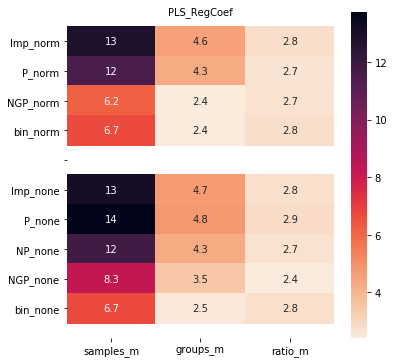

In [119]:
f, ax = plt.subplots(figsize=(6, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

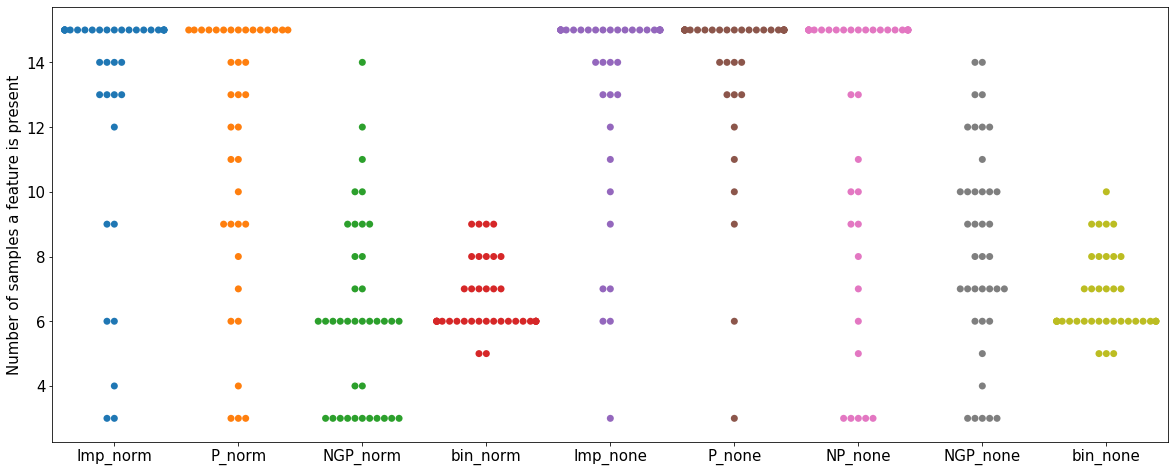

In [120]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 7)
ax.set(xticklabels = [list(PLS_Feat.keys())[i] for i in range(len(PLS_Feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [121]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[23.475022361086587, 8.963804193937266, 2.760849637237065, 2.6791390742625927, 31.636093029197404, 11.317513589707865, 10.47290463109467, 4.520561864376683, 2.6858061819583487]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the non previously normalized dataset (None)

In [122]:
from sklearn.cross_decomposition import PLSRegression

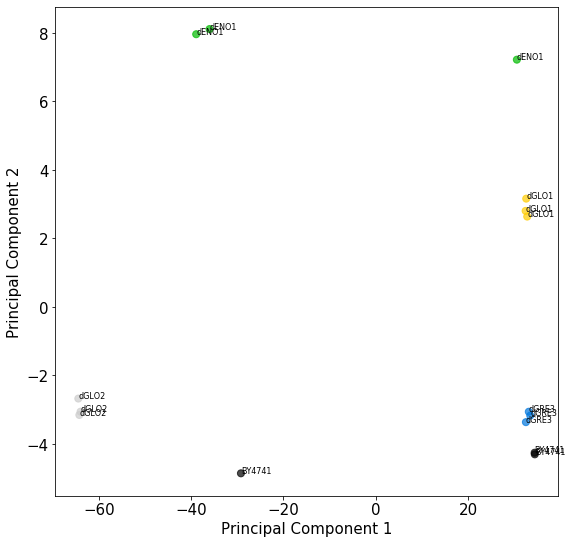

In [123]:
plsda = PLSRegression(n_components=6)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_none.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

# PC scatter plot
labels = Spectra.ms.unique_labels
ax = LV_score.iloc[:, 0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c=col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size=15)
ax.set_ylabel(ylabel = 'Principal Component 2', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = labels[i] # label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the non previously normalized dataset (None)

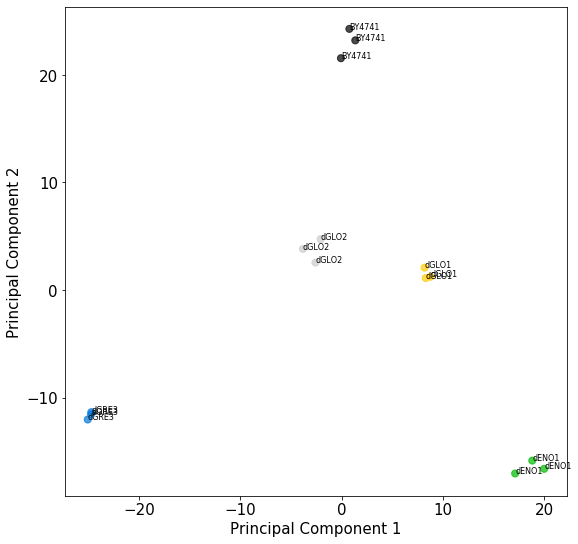

In [124]:
plsda = PLSRegression(n_components = 6)
#Fitting the model and getting the X_scores
plsda.fit(X=binary_none.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

labels = Spectra.ms.unique_labels

# PC scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [125]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (Imp_norm, P_norm, NGP_norm, Imp_none, P_none, NP_none, NGP_none, binary_norm, binary_none)
names = ('Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none', 'NGP_none', 'bin_norm', 'bin_none')
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=6, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Imp_norm ...
Done!
permutation test (PLS-DA) for P_norm ...
Done!
permutation test (PLS-DA) for NGP_norm ...
Done!
permutation test (PLS-DA) for Imp_none ...
Done!
permutation test (PLS-DA) for P_none ...
Done!
permutation test (PLS-DA) for NP_none ...
Done!
permutation test (PLS-DA) for NGP_none ...
Done!
permutation test (PLS-DA) for bin_norm ...
Done!
permutation test (PLS-DA) for bin_none ...
Done!


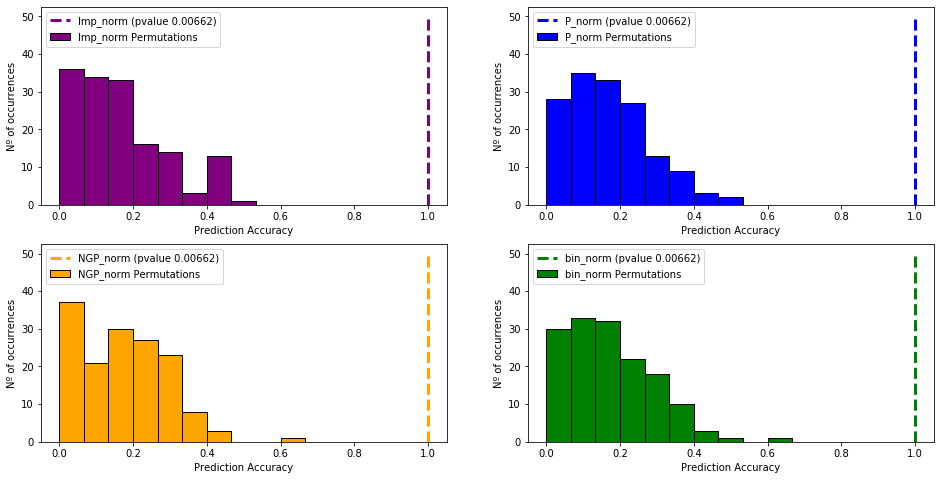

In [126]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp_norm', 'P_norm', 'NGP_norm', 'bin_norm']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_norm.ms.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

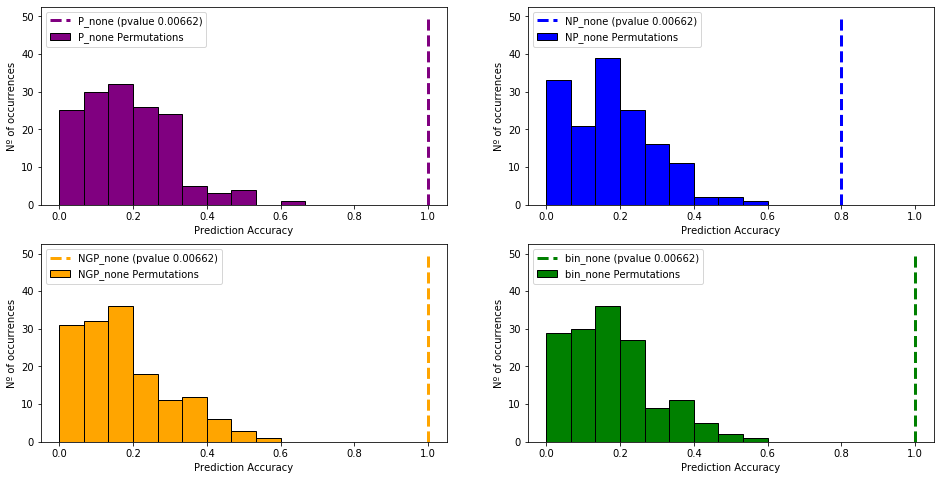

In [127]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_none', 'NP_none', 'NGP_none', 'bin_none']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_norm.ms.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

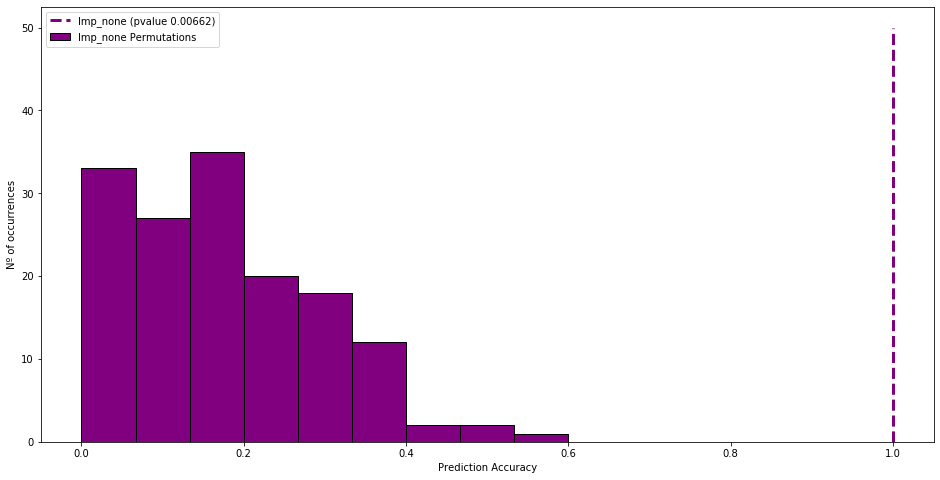

In [128]:
f, axes = plt.subplots(1, 1, figsize = (16,8))

Names = ['Imp_none']
color = ['purple']
ylim = [0,50]
for i in range(len(Names)):
    plt.hist(PMs_PLS[Names[i]], len(NGP_none.ms.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    plt.plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %.5f)' % pvalue_PLS[Names[i]])
    plt.xlabel('Prediction Accuracy')
    plt.ylabel('Nº of occurrences')
    plt.legend()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

In [129]:
CV = {}
PMs = {}
pvalue = {}

all_data = (Imp_norm, P_norm, NGP_norm, Imp_none, P_none, NP_none, NGP_none, binary_norm, binary_none)
names = ('Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none', 'NGP_none', 'binary_norm', 'binary_none')
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Imp_norm ...
Done!
Permutation test (Random Forest) for P_norm ...
Done!
Permutation test (Random Forest) for NGP_norm ...
Done!
Permutation test (Random Forest) for Imp_none ...
Done!
Permutation test (Random Forest) for P_none ...
Done!
Permutation test (Random Forest) for NP_none ...
Done!
Permutation test (Random Forest) for NGP_none ...
Done!
Permutation test (Random Forest) for binary_norm ...
Done!
Permutation test (Random Forest) for binary_none ...
Done!


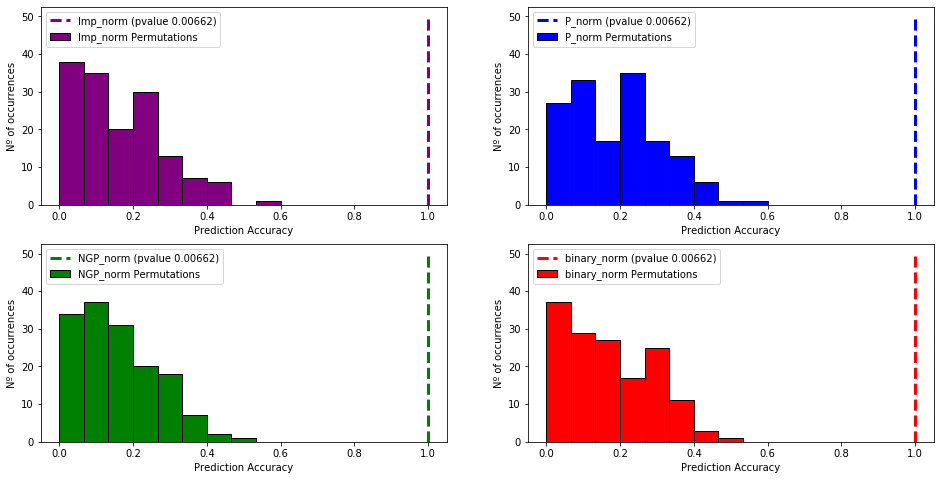

In [130]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp_norm', 'P_norm', 'NGP_norm', 'binary_norm']
colors = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_norm.ms.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

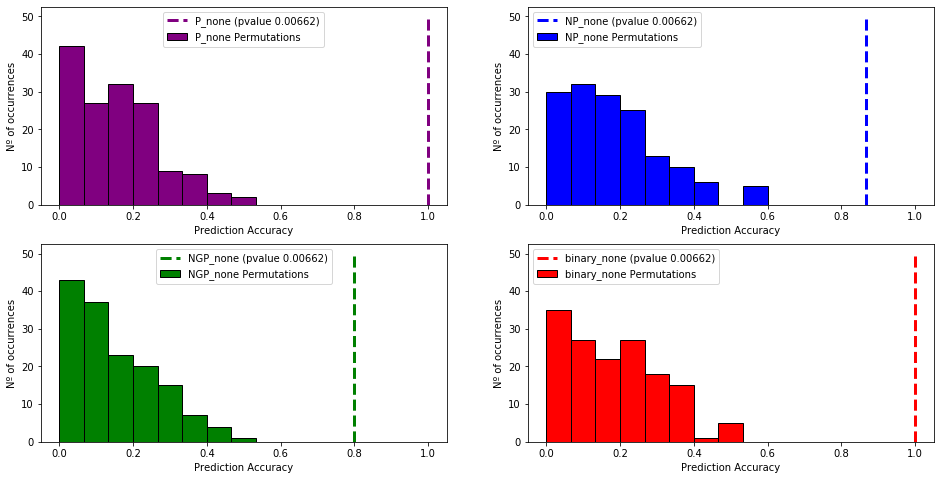

In [131]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_none', 'NP_none', 'NGP_none', 'binary_none']
colors = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_none.ms.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

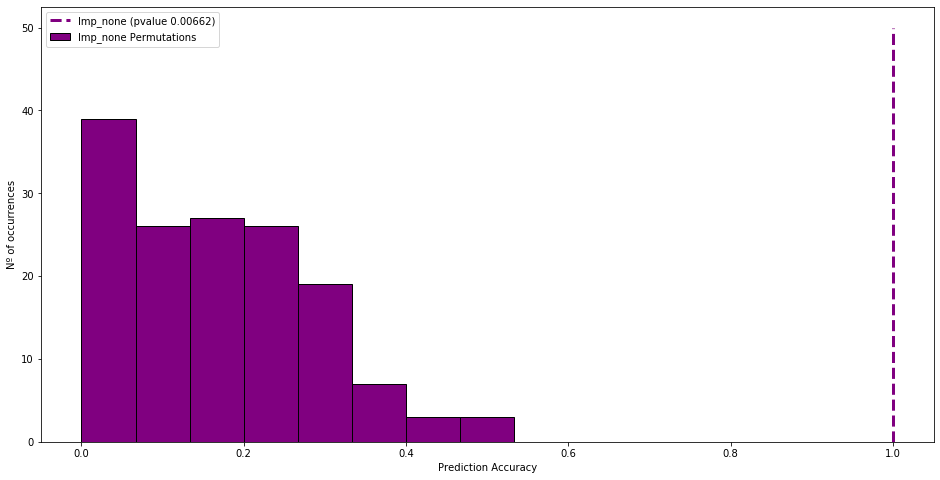

In [132]:
f, axes = plt.subplots(1, 1, figsize = (16,8))

Names = ['Imp_none']
color = ['purple']
ylim = [0,50]
for i in range(len(Names)):
    plt.hist(PMs[Names[i]], len(NGP_none.ms.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    plt.plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %.5f)' % pvalue[Names[i]])
    plt.xlabel('Prediction Accuracy')
    plt.ylabel('Nº of occurrences')
    plt.legend()

In [133]:
def Feat_Selection_sim(VIP_s, Weight_s, RegCoef_s, percent = 0.02):
    """See the similarity of features chosen (% of intersection between them) with different methods."""
    number = round(percent * len(VIP_s))
    VIP = []
    Weights = []
    RegCoef = []
    for i in range(number):
        VIP.append(VIP_s[:number][i][0])
        Weights.append(Weight_s[:number][i][0])
        RegCoef.append(RegCoef_s[:number][i][0])
    Features = (VIP, Weights, RegCoef)
    Table = pd.DataFrame(np.empty((3,3)), columns = ['VIP', 'Weights', 'RegCoef'], index = ['VIP', 'Weights', 'RegCoef'])
    for i in range(len(Features)):
        for j in range(len(Features)):
            #list comprehension other way
            Table.iloc[i,j] = len(set(Features[i]).intersection(Features[j]))/number
    return Table